In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "torch"


In [2]:
import keras
import keras_tuner as kt
keras.utils.set_random_seed(812)

2024-06-15 20:02:21.293961: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 20:02:21.317436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 20:02:21.825436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Planted motifs: 80
[0, 10, 25, 35, 50, 60, 75, 85, 100, 110, 125, 135, 150, 160, 175, 185, 200, 210, 225, 235, 250, 260, 275, 285, 300, 310, 325, 335, 350, 360, 375, 385, 400, 410, 425, 435, 450, 460, 475, 485, 500, 510, 525, 535, 550, 560, 575, 585, 600, 610, 625, 635, 650, 660, 675, 685, 700, 710, 725, 735, 750, 760, 775, 785, 800, 810, 825, 835, 850, 860, 875, 885, 900, 910, 925, 935, 950, 960, 975, 985]


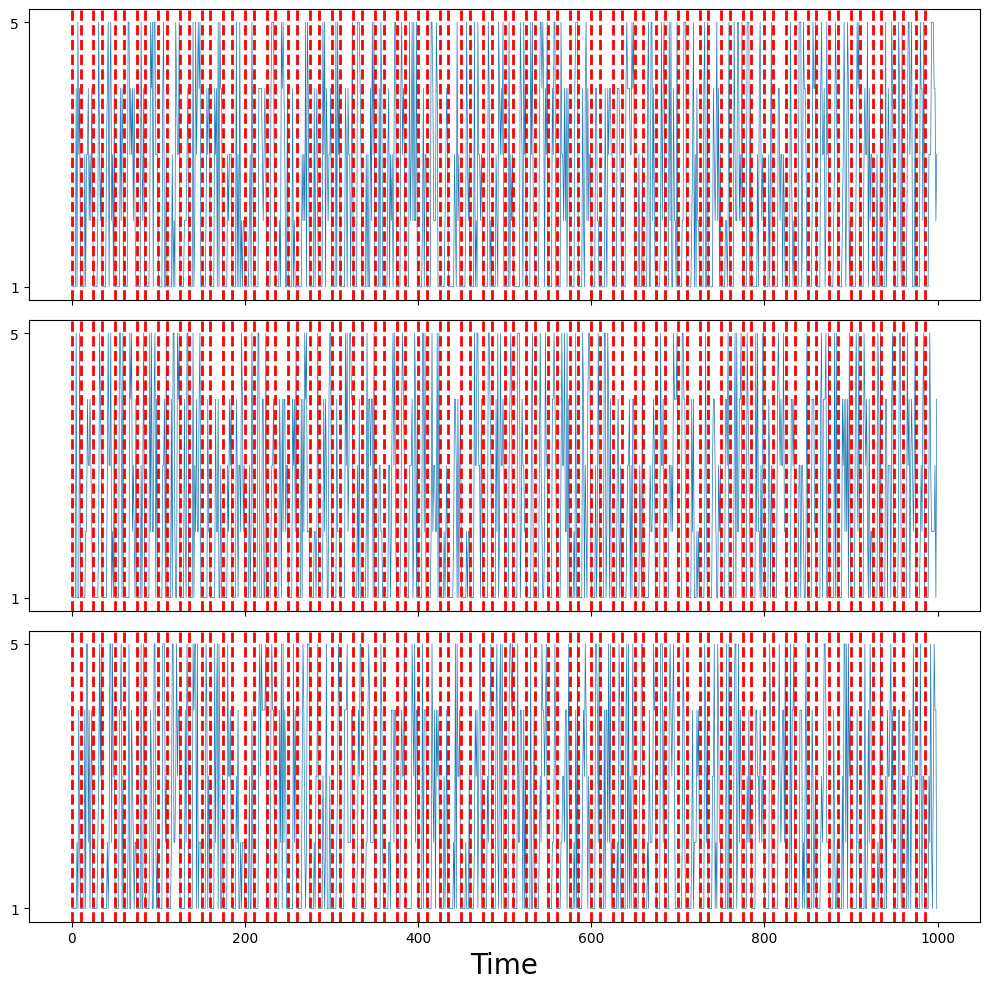

In [5]:
#fixed frequency repetitions
n = 1000
k = 3
variable_indexes = range(k)
data = np.random.randint(1, 6, (k, n)) #k timeseries of length n
#put the pattern every 1000 indexes
motif_indexes_scenario1 = []
motif_pattern = [1, 1, 1, 1, 1]
p = len(motif_pattern)

# Initialize the index and step counters
index = 0
step = 10
# Loop through the array with alternating steps
while index < n:
    motif_indexes_scenario1.append(index)
    data[:, index:index + p] = motif_pattern
    
    # Alternate between steps of 10 and 15 indices
    if step == 10:
        index += 10
        step = 15
    else:
        index += 15
        step = 10

print("Planted motifs:", len(motif_indexes_scenario1))
print(motif_indexes_scenario1)

#save to file as csv
data_scenario_fixed_frequency = data.astype(int)
np.savetxt("../data/syntheticdata/scenario1_k=3.csv", data_scenario_fixed_frequency, delimiter=",")
np.savetxt("../data/syntheticdata/motif_indexes_scenario1_k=3.csv", motif_indexes_scenario1, delimiter=",")

#plot multivariate data using subplots in red the planted motifs
fig, axis = plt.subplots(nrows=k, ncols=1, figsize=(10, 10), sharex=True)
for i, variable in enumerate(variable_indexes):
 plt.subplot(len(variable_indexes), 1, i+1)
 #y axis from 1 to 5
 plt.yticks([1,5])
 plt.plot(data_scenario_fixed_frequency[variable], linewidth=0.5)
 #plot the planted motifs
 for idx in motif_indexes_scenario1:
    plt.axvline(x=idx, color='r', linestyle='--', linewidth = 2)

plt.xlabel('Time', size=20)
plt.tight_layout()
plt.savefig("../images/data_scenario1.pdf")
plt.show()

In [6]:
from keras.preprocessing.sequence import pad_sequences

def create_dataset(data,variable_indexes, lookback_period, step, forecast_period, motif_indexes):
    X1, X2, y = list(), list(),  list() # X1: data, X2: indexes of the motifs, y: distance to the next motif
    for idx in range(len(data[0]) - lookback_period - 1):
        if idx % step != 0:
            continue

        window_end_idx = idx + lookback_period
        forecast_period__end = window_end_idx + forecast_period

        #if doesnt exist more matches after the window
        if not any([window_end_idx < motif_idx for motif_idx in motif_indexes]):
            break

        #motifs_indexes_in_window relative to the window
        motif_indexes_in_window = [motif_idx - idx for motif_idx in motif_indexes if idx <= motif_idx <= window_end_idx]
        motif_indexes_in_forecast_period = [motif_idx for motif_idx in motif_indexes if window_end_idx < motif_idx <= forecast_period__end]

        if motif_indexes_in_forecast_period:
            next_match_in_forecast_period = motif_indexes_in_forecast_period[0]
        else:
            next_match_in_forecast_period = -1  #no match in forward window but exist in the future

        data_window = data[variable_indexes,idx:window_end_idx]

        data_y = -1 
        if next_match_in_forecast_period != -1:
            # index of the next match relative to the last match in the window
            #data_y = next_match_in_forecast_period - motif_indexes_in_window[-1] 
            # index of the next match relative to the end of the window
            data_y = next_match_in_forecast_period - window_end_idx
        
        X1.append(data_window)
        X2.append(motif_indexes_in_window) 
        y.append(data_y) 

    X2 = pad_sequences(X2, padding='post', value=-1, dtype=int)
    return np.array(X1), np.array(X2) , np.array(y)

In [7]:
#load data
data_scenario1 = np.genfromtxt("../data/syntheticdata/scenario1_k=3.csv", delimiter=",")
data_scenario1 = data_scenario1.astype(int)
data_scenario1 = data_scenario1.reshape((k, n))

motif_indexes_scenario1 = np.genfromtxt("../data/syntheticdata/motif_indexes_scenario1_k=3.csv", delimiter=",")
motif_indexes_scenario1= motif_indexes_scenario1.astype(int)


lookback_period = 100 #window size
step = 1 #step size for the sliding window
forecast_period = 50 #forward window size
#x1: past window + masking, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2 , y  = create_dataset(data_scenario1,variable_indexes=np.arange(k), lookback_period=lookback_period, step=step, forecast_period=forecast_period, motif_indexes=motif_indexes_scenario1)
print(X1.shape, X2.shape, y.shape)
print(X1[0,0], X2[0], y[0])

X1 = np.transpose(X1, (0, 2, 1)) #reshape input to be [samples, time steps, features]
X2 = X2.reshape(X2.shape[0], X2.shape[1], 1) #reshape input to be [samples, time steps, features]
pattern_array = np.tile(motif_pattern, (X1.shape[0], 1)).reshape(X1.shape[0], p, 1)
X1.shape, X2.shape, pattern_array.shape

(885, 3, 100) (885, 9) (885,)
[1 1 1 1 1 4 1 5 3 4 1 1 1 1 1 3 1 3 3 4 2 3 2 4 2 1 1 1 1 1 2 5 3 2 3 1 1
 1 1 1 3 4 5 1 4 5 2 3 1 4 1 1 1 1 1 1 4 2 4 3 1 1 1 1 1 5 5 3 4 3 4 2 4 2
 1 1 1 1 1 1 5 3 2 4 1 1 1 1 1 1 2 5 4 5 1 5 5 3 3 3] [  0  10  25  35  50  60  75  85 100] 10


((885, 100, 3), (885, 9, 1), (885, 5, 1))

In [8]:
class BlockingTimeSeriesSplit():
  def __init__(self, n_splits):
      self.n_splits = n_splits

  def get_n_splits(self, X, y, groups):
      return self.n_splits

  def split(self, X, y=None, groups=None):
      n_samples = len(X)
      k_fold_size = n_samples // self.n_splits
      indices = np.arange(n_samples)

      margin = 0
      for i in range(self.n_splits):
          start = i * k_fold_size
          stop = start + k_fold_size
          mid = int(0.8 * (stop - start)) + start
          yield indices[start: mid], indices[mid + margin: stop]

In [9]:
from keras.optimizers import Adam
from keras.layers import Dense, Masking, Concatenate, Flatten, Conv1D
from keras import Input
from tqdm.keras import TqdmCallback

class MyHyperModel_CNN(kt.HyperModel):
    def __init__(self,time_series_shape, masked_series_shape):
        self.time_series_shape = time_series_shape
        self.masked_series_shape = masked_series_shape 
        #self.motif_indexes_shape = motif_indexes_shape
        #self.pattern_shape = pattern_shape

    def build(self, hp):
        series_input = Input(shape=self.time_series_shape) # (observations, time steps, features)
        masked_series_input = Input(shape=self.masked_series_shape) # (observations, time steps, 1)
        #motif_indexes_input = Input(shape=self.motif_indexes_shape) # (observations, numer_indexes, 1)
        #pattern_input = Input(shape=self.pattern_shape) # (observations, pattern_size, 1)
         
        #motif_indexes_input = Masking(mask_value=-1)(motif_indexes_input)


        concat = Concatenate(axis=2)([series_input, masked_series_input])


        conv_1d = Conv1D(filters=hp.Choice('filters', values=[32,64,128]), kernel_size=hp.Choice('kernel_size', values=[3,5]), activation='relu')(concat)
        
        
        series_flatten = Flatten()(conv_1d)

        units_dense1 = hp.Choice('units', values=[64])
        dense1 = Dense(units = units_dense1, activation='relu')(series_flatten)
        dense2 = Dense(units = units_dense1/2, activation='relu')(dense1)
        output = Dense(1)(dense2)
        model = keras.Model(inputs=[series_input, masked_series_input], outputs=output)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae', 'root_mean_squared_error', 'r2_score'])
        return model

In [10]:
X1[0,:,:].flatten(), X2[0,:,:].flatten(), pattern_array[0,:,:].flatten(), y[0]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 5, 1, 1, 1, 2, 5,
        1, 1, 3, 1, 4, 4, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 3, 1, 4, 1, 2, 1, 3, 2, 5, 3, 4, 5, 4, 3, 2, 2, 3, 4, 3, 4, 1,
        2, 3, 3, 4, 2, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 2, 5, 2, 3, 3, 5, 5, 2, 4, 3, 3, 3, 5, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 4, 3, 2, 5, 5, 1, 1, 3, 2,
        4, 3, 5, 5, 5, 5, 2, 1, 2, 3, 2, 5, 1, 1, 3, 4, 4, 3, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 4, 4, 5, 4, 2, 4, 5, 4, 1,
        1, 3, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 2,
        5, 1, 5, 3, 5, 1, 4, 4, 1, 3, 5, 4, 4, 2, 3, 2, 3, 2, 4, 2, 1, 2,
        1, 2, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 3,
        5, 3, 1, 1, 2, 3, 1, 4, 5, 5, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 5, 2, 5, 2, 4, 4, 5, 3, 5, 2, 1, 1, 2, 1, 5,
        4, 5, 5, 5, 5, 3, 1, 2, 3, 4, 

In [11]:
import collections
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
import pickle

class CVTuner(kt.engine.tuner.Tuner):

    def __init__(self, *args, **kwargs):
        super(CVTuner, self).__init__(*args, **kwargs)
        # cols are metrics-val_loss, val_mae, val_rmse, val_r2
        self.metrics_history = []
        #if exists load metrics history
        if os.path.exists(os.path.join(self.project_dir, "metrics_history.npy")):
            self.metrics_history = np.load(os.path.join(self.project_dir, "metrics_history.npy"), allow_pickle=True)
        

    def run_trial(self, trial, x, y, *args, **kwargs):
        callbacks = kwargs.pop("callbacks", [])
        callbacks.append(EarlyStopping(patience=10, monitor="val_loss", start_from_epoch = 100))
        verbose = kwargs.pop("verbose", 0)
        batch_size = trial.hyperparameters.Choice('batch_size', values=[8,16,32])

        metrics = collections.defaultdict(list)
        cv = BlockingTimeSeriesSplit(n_splits=5)
        trial_metrics = np.zeros((5, 4), dtype=np.float32)

        for i, (train_indices, test_indices) in enumerate(cv.split(y)):
            #split train indices into train and validation
            #if x is list
            if isinstance(x, list):
                X_train = [x_in[train_indices] for x_in in x]
                X_test = [x_in[test_indices] for x_in in x]
            else:
                X_train, X_test = x[train_indices], x[test_indices]
            y_train, y_test = y[train_indices], y[test_indices]

            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(X_train, y_train, validation_split=0.2, epochs=400, batch_size=batch_size, verbose=verbose, callbacks=callbacks)
            test_loss, test_mae, test_rmse, test_r2 = model.evaluate(X_test, y_test) 
            metrics["test_loss"].append(test_loss)
            metrics["test_mae"].append(test_mae)
            metrics["test_rmse"].append(test_rmse)
            metrics["test_r2"].append(test_r2)

            trial_metrics[i] = [test_loss, test_mae, test_rmse, test_r2]
                
        self.save_trial_metrics(trial.trial_id, trial_metrics)
        self.metrics_history.append(trial_metrics)
        print({name: np.mean(values) for name, values in metrics.items()})
        #save cross validation metrics
        return {name: np.mean(values) for name, values in metrics.items()}

    def save_trial_metrics(self, trial_id, metrics):
        fname = os.path.join(self.get_trial_dir(trial_id), "metrics.pickle")
        with open(fname, "wb") as f:
            pickle.dump(metrics, f)

    def save_metrics(self):
        # aggregate metric_history into a matrix (num trials, num folds, num metrics)
        fname = os.path.join(self.project_dir, "metrics_history.npy")
        np.save(fname, np.array(self.metrics_history))
    
    def save_model(self, trial_id, model, step=0):
        fname = os.path.join(self.get_trial_dir(trial_id), "model.pickle")
        with open(fname, "wb") as f:
            pickle.dump(model, f)

    def load_model(self, trial):
        fname = os.path.join(self.get_trial_dir(trial.trial_id), "model.pickle")
        with open(fname, "rb") as f:
            return pickle.load(f)


In [17]:
from sklearn.preprocessing import MinMaxScaler
#Masking the data for input, only 1 in motif indexes rest is zero
masking_X1 = np.zeros((X1.shape[0], X1.shape[1], 1))
for i, obs_motif_indexes in enumerate(X2):
    for j, idx in enumerate(obs_motif_indexes):
        masking_X1[i, idx[0]:idx[0]+5, 0] = 1

X1_normalized = X1.copy()
scalers = []
for i in range(X1.shape[2]):
    scaler = MinMaxScaler()
    X1_normalized[:,:,i] = scaler.fit_transform(X1[:,:,i])
    scalers.append(scaler)

#X1_normalized_plus_masking = np.concatenate([X1_normalized, masking_X1], axis=2)

tuner = CVTuner(
  hypermodel=MyHyperModel_CNN(time_series_shape=(X1_normalized.shape[1], X1_normalized.shape[2]),masked_series_shape=(masking_X1.shape[1], masking_X1.shape[2])),
  oracle=kt.oracles.GridSearchOracle(
    objective=kt.Objective("test_loss", "min"),
    max_trials=None),
    directory='../results/syntheticdata',
    project_name='series_fixedfrequency_k=3_cnn_series+masked_series')

tuner.search(
        x= [X1_normalized, masking_X1],
        y=y,
        verbose=0,
        callbacks=[TqdmCallback(verbose=0)],
    )
tuner.save_metrics()

Reloading Tuner from ../results/syntheticdata/series_fixedfrequency_10_15_k=3_cnn_series+masked_series/tuner0.json


0epoch [00:00, ?epoch/s]

In [13]:
tuner.results_summary()

Results summary
Results in ../results/syntheticdata/series_fixedfrequency_10_15_k=3_cnn_masked_series
Showing 10 best trials
Objective(name="test_loss", direction="min")

Trial 0001 summary
Hyperparameters:
filters: 32
kernel_size: 3
units: 64
learning_rate: 0.001
batch_size: 16
Score: 1.8191867689988303e-13

Trial 0037 summary
Hyperparameters:
filters: 128
kernel_size: 3
units: 64
learning_rate: 0.001
batch_size: 16
Score: 1.9928750219066342e-13

Trial 0010 summary
Hyperparameters:
filters: 32
kernel_size: 5
units: 64
learning_rate: 0.001
batch_size: 16
Score: 2.4002528751457946e-13

Trial 0028 summary
Hyperparameters:
filters: 64
kernel_size: 5
units: 64
learning_rate: 0.001
batch_size: 16
Score: 2.6165736176603055e-13

Trial 0046 summary
Hyperparameters:
filters: 128
kernel_size: 5
units: 64
learning_rate: 0.001
batch_size: 16
Score: 3.079413216392976e-13

Trial 0019 summary
Hyperparameters:
filters: 64
kernel_size: 3
units: 64
learning_rate: 0.001
batch_size: 16
Score: 3.5452134934

In [18]:
#get config of the best model
best_trial = tuner.oracle.get_best_trials(1)[0]

print(best_trial.hyperparameters.values)
print(best_trial.metrics.get_best_value("test_mae"))

#load best trial metrics file
cv_metrics = np.load(os.path.join(tuner.get_trial_dir(best_trial.trial_id), "metrics.pickle"), allow_pickle=True)
print([row[1] for row in cv_metrics])

{'filters': 128, 'kernel_size': 3, 'units': 64, 'learning_rate': 0.001, 'batch_size': 16}
1.7020437610426596e-07
[1.9205942e-07, 5.9604645e-08, 2.7484364e-07, 2.2848447e-07, 9.602971e-08]


In [15]:
#get config of the best model
best_trial = tuner.oracle.get_best_trials(1)[0]

print(best_trial.hyperparameters.values)
print(best_trial.metrics.get_best_value("test_mae"))

#load best trial metrics file
cv_metrics = np.load(os.path.join(tuner.get_trial_dir(best_trial.trial_id), "metrics.pickle"), allow_pickle=True)
print(cv_metrics)

df_cv_metrics = pd.DataFrame({
    'Mean': np.mean(cv_metrics, axis=0),
    'STD': np.std(cv_metrics, axis=0)
}, index=['Loss', 'MAE', 'RMSE', 'R2'])
print(df_cv_metrics)

metrics = []
#train test split
mid = int(0.8 * len(np.arange(len(X1))))
X1_train, X1_test = X1[:mid], X1[mid:]
X2_train, X2_test = X2[:mid], X2[mid:]
pattern_array_train, pattern_array_test = pattern_array[:mid], pattern_array[mid:]
y_train, y_test = y[:mid], y[mid:]
model = (MyHyperModel_CNN(time_series_shape=(X1.shape[1], X1.shape[2]), motif_indexes_shape=(X2.shape[1], X2.shape[2]), pattern_shape=(pattern_array.shape[1], pattern_array.shape[2]))).build((best_trial.hyperparameters))
history = model.fit([X1_train, X2_train, pattern_array_train], y_train, validation_split = 0.2,
            epochs=400, batch_size=best_trial.hyperparameters.values["batch_size"],
            verbose=0, callbacks=[TqdmCallback(verbose=1)])
metrics.append(model.evaluate([X1_test, X2_test, pattern_array_test], y_test))


keras.utils.plot_model(model, to_file="../images/best_model_cnn_casestudy_fixedfrequency_10_15_k=3.png", show_shapes=True)
metrics = np.array(metrics)
print(metrics)

{'filters': 32, 'kernel_size': 7, 'units': 64, 'learning_rate': 0.001, 'batch_size': 8}
0.04891481250524521
[[1.1498664e-02 7.5973719e-02 1.0723182e-01 9.9917918e-01]
 [7.5767348e-03 6.8240434e-02 8.7044440e-02 9.9945313e-01]
 [9.1804448e-04 2.6120912e-02 3.0299248e-02 9.9993402e-01]
 [7.6489773e-04 2.0999249e-02 2.7656784e-02 9.9994612e-01]
 [3.2897075e-03 5.3239748e-02 5.7355970e-02 9.9977601e-01]]
          Mean       STD
Loss  0.004810  0.004152
MAE   0.048915  0.022015
RMSE  0.061918  0.031238
R2    0.999658  0.000298


TypeError: __init__() got an unexpected keyword argument 'motif_indexes_shape'

In [ ]:
import pandas as pd
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs["loss"], lw=2, label='training loss')
plt.plot(logs["val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs["mae"], lw=2, label='training MAE')
plt.plot(logs["val_mae"], lw=2, label='validation MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend(loc='upper right')
plt.show()

In [ ]:
#plot prediction vs true values
y_pred = model.predict([X1_test, X2_test, pattern_array_test])

residuals = y_test - y_pred.flatten()
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.show()